# Leveraging XLM-RoBERTa for Hate Speech Detection in Mixed-Language Texts

---

### Author: **Farrel Dinarta**  
**Student ID**: 00000055702  
**Email**: [farrel.dinarta@student.umn.ac.id](mailto:farrel.dinarta@student.umn.ac.id)

---

In [ ]:
!pip install --upgrade tensorflow

### Pre-trained Model Fine Tuning

Constants

In [ ]:
# Google Drive constants
DRIVE_MOUNT_PATH = '/content/drive'
DRIVE_WORKDIR_PATH = f'{DRIVE_MOUNT_PATH}/MyDrive/mixed-code-hate-speech-research'

# Dataset-related constants
DATASET_DIR_PATH = f'{DRIVE_WORKDIR_PATH}/dataset'
DATASET_PATH = f'{DATASET_DIR_PATH}/dataset_final.csv'

# Model-related constants
MODEL_NAME = 'xlm-roberta-base'
FINE_TUNED_MODEL_OUTPUT_PATH = f'{DRIVE_WORKDIR_PATH}/xlm_roberta_base_tuned_EPOCH_PROGRESSIVE_14'
BEST_FINE_TUNED_MODEL_OUTPUT_PATH = f'{DRIVE_WORKDIR_PATH}/xlm_roberta_base_tuned_CHECKPOINT_4'

# Dataset split related constants
EVALUATION_SIZE = 0.3
TEST_SIZE = 1/3
RANDOM_STATE = 42

# Hyper-parameter constants
BATCH_SIZE = 32
EPOCHS = 5
MINIMUM_EPOCHS = 5
MAXIMUM_EPOCHS = 50
EPOCHS_DELTA = 5
LEARNING_RATE = 2e-5
OPTIMIZER_EPS = 1e-8

# Fine-tuning parameter constants
TOKEN_MAX_LENGTH_PERCENTILE = 0.95

Import necessary libraries

In [ ]:
from transformers import XLMRobertaTokenizer, TFXLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup, create_optimizer
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset

import os

import re
import random

Mount Google Drive for Google Colab usage

In [ ]:
from google.colab import drive
drive.mount(DRIVE_MOUNT_PATH)

Mounted at /content/drive


Set Seeds

In [ ]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

Check if GPU is available

In [ ]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("Using CPU, no GPU detected.")

GPU is available.


Load pre-trained model and tokenizer

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
model = TFXLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # labels is set to 2 for binary classification (hate speech and non-hate speech)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load dataset

In [ ]:
df = pd.read_csv(DATASET_PATH)

Get dataset length

In [ ]:
print(f'Dataset length : {len(df)}')

Dataset length : 30000


Dataset preview

In [ ]:
print('\nDataset Preview : ')
print(df.head())


Dataset Preview : 
                                            sentence  label
0  Using derogatory language towards referees dur...    1.0
1  The rig supports local community projects, men...    0.0
2  Mereka datang hanya untuk berisik, no respect ...    1.0
3  Artists and writers find inspiration in the pr...    0.0
4  Appreciation emails boost morale, bikin semang...    0.0


Preprocessing modules

In [ ]:
class XLMRoBERTaTextPreprocessor:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def handle_contractions(self, text):
        """Expand contractions in the text."""
        contractions_dict = {
            "can't": "cannot",
            "won't": "will not",
            "I'm": "I am",
            "you're": "you are",
            "he's": "he is",
            "she's": "she is",
            "it's": "it is",
            "we're": "we are",
            "they're": "they are",
            "I've": "I have",
            "wasn't": "was not",
            "didn't": "did not",
            "don't": "do not",
            "hasn't": "has not",
            "haven't": "have not",
            "wouldn't": "would not",
            "shouldn't": "should not",
            "couldn't": "could not"
        }

        for contraction, expanded in contractions_dict.items():
            text = text.replace(contraction, expanded)

        return text

    def normalize_whitespace(self, text):
        """Replace multiple spaces with a single space."""
        return re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace and strip leading/trailing spaces

    def remove_special_characters(self, text):
        """Remove special characters from the text."""
        return re.sub(r'[^\w\s]', '', text)  # Remove special characters

    def lowercase(self, text):
        """Convert text to lowercase."""
        return text.lower()

    def tokenize(self, text, max_length):
        """Tokenize the text using XLM-RoBERTa tokenizer."""
        """Including subword tokenization, padding, and truncation"""
        return self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='tf'
        )


def find_optimized_token_length(df):
    df['token_length'] = df['sentence'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))

    percentile = df['token_length'].quantile(TOKEN_MAX_LENGTH_PERCENTILE)
    print(f"{TOKEN_MAX_LENGTH_PERCENTILE * 100}th percentile token length: {percentile}")

    # Plot token length distribution
    df['token_length'].plot(kind='hist', bins=30, edgecolor='black')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.title('Token Length Distribution')
    plt.show()

    return percentile


Initialize Preprocessing Module

In [ ]:
preprocessor = XLMRoBERTaTextPreprocessor(tokenizer)

Preprocessing Step 1 : Contractions Handling

In [ ]:
df['sentence'] = df['sentence'].apply(preprocessor.handle_contractions)
print('\nContractions handling result : ')
print(df.head())


Contractions handling result : 
                                            sentence  label
0  Using derogatory language towards referees dur...    1.0
1  The rig supports local community projects, men...    0.0
2  Mereka datang hanya untuk berisik, no respect ...    1.0
3  Artists and writers find inspiration in the pr...    0.0
4  Appreciation emails boost morale, bikin semang...    0.0


Preprocessing Step 2 : Special Characters Removal

In [ ]:
df['sentence'] = df['sentence'].apply(lambda x : preprocessor.remove_special_characters(x))
print('\nSpecial characters removal result : ')
print(df.head())


Special characters removal result : 
                                            sentence  label
0  Using derogatory language towards referees dur...    1.0
1  The rig supports local community projects mend...    0.0
2  Mereka datang hanya untuk berisik no respect f...    1.0
3  Artists and writers find inspiration in the pr...    0.0
4  Appreciation emails boost morale bikin semanga...    0.0


Preprocessing Step 3 : Whitespace Normalization

In [ ]:
df['sentence'] = df['sentence'].apply(preprocessor.normalize_whitespace)
print('\nWhitespace normalization result : ')
print(df.head())


Whitespace normalization result : 
                                            sentence  label
0  Using derogatory language towards referees dur...    1.0
1  The rig supports local community projects mend...    0.0
2  Mereka datang hanya untuk berisik no respect f...    1.0
3  Artists and writers find inspiration in the pr...    0.0
4  Appreciation emails boost morale bikin semanga...    0.0


Preprocessing Step 4 : Lowercasing

In [ ]:
df['sentence'] = df['sentence'].apply(preprocessor.lowercase)
print('\nLowercasing result : ')
print(df.head())


Lowercasing result : 
                                            sentence  label
0  using derogatory language towards referees dur...    1.0
1  the rig supports local community projects mend...    0.0
2  mereka datang hanya untuk berisik no respect f...    1.0
3  artists and writers find inspiration in the pr...    0.0
4  appreciation emails boost morale bikin semanga...    0.0


Find the most optimized max token length

95.0th percentile token length: 23.0


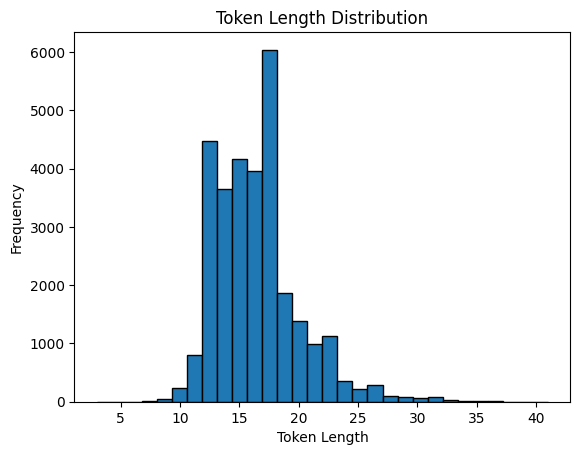

Max token length : 23


In [ ]:
max_length = int(find_optimized_token_length(df))
print(f'Max token length : {max_length}')

Drop duplicates if exists

In [ ]:
df = df.drop_duplicates(subset=['sentence'])

Split Dataset

In [ ]:
texts = df['sentence'].values
labels = df['label'].values  # 0 represents non-hate speech, 1 represents hate-speech

# Set training size to 70%, 20% for validation, and 10% for test.
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=EVALUATION_SIZE, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=TEST_SIZE, random_state=RANDOM_STATE)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(f"Training set length: {len(X_train)}")
print(f"Validation set length: {len(X_val)}")
print(f"Test set length: {len(X_test)}")

(20802,) (20802, 2)
(5944,) (5944, 2)
(2972,) (2972, 2)
Training set length: 20802
Validation set length: 5944
Test set length: 2972


Label Counts for Training, Validation, and Test Set

In [ ]:
# Count labels for each split
train_label_counts = pd.Series(y_train.argmax(axis=1)).value_counts()
val_label_counts = pd.Series(y_val.argmax(axis=1)).value_counts()
test_label_counts = pd.Series(y_test.argmax(axis=1)).value_counts()

# Print label counts
print("\nTraining label counts:\n", train_label_counts)
print("\nValidation label counts:\n", val_label_counts)
print("\nTest label counts:\n", test_label_counts)


Training label counts:
 0    10435
1    10367
Name: count, dtype: int64

Validation label counts:
 1    3027
0    2917
Name: count, dtype: int64

Test label counts:
 0    1488
1    1484
Name: count, dtype: int64


Check for Data Leakage

In [ ]:
# Convert to sets for unique values
train_texts_set = set(X_train)
val_texts_set = set(X_val)

# Find intersection
leakage = train_texts_set.intersection(val_texts_set)
if leakage:
    print(f'Data leakage detected! {len(leakage)} duplicate(s) found.\n')
    print("Duplicate texts:")
    for text in leakage:
        print(text)
else:
    print("No data leakage detected.")

No data leakage detected.


Tokenization (include sub-word tokenization, padding, and truncation)

In [ ]:
train_encodings = preprocessor.tokenize(X_train.tolist(), max_length)
val_encodings = preprocessor.tokenize(X_val.tolist(), max_length)
test_encodings = preprocessor.tokenize(X_test.tolist(), max_length)

In [ ]:
print(train_encodings)

{'input_ids': <tf.Tensor: shape=(20802, 23), dtype=int32, numpy=
array([[     0,     70, 227234, ...,    331,   2747,      2],
       [     0,    352,  62783, ...,      1,      1,      1],
       [     0,  65296,  54704, ...,      1,      1,      1],
       ...,
       [     0,  17368,    182, ...,    164,    123,      2],
       [     0,    642,   3871, ...,      1,      1,      1],
       [     0,  28512,    119, ...,      1,      1,      1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(20802, 23), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


Create Tensorflow Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    y_train
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask']
    },
    y_val
)).batch(BATCH_SIZE)

Custom Learning Rate Scheduler Module

In [ ]:
# class LearningRateScheduler(tf.keras.callbacks.Callback):
#     def __init__(self, initial_lr, total_steps, warmup_steps):
#         super().__init__()
#         self.initial_lr = initial_lr
#         self.total_steps = total_steps
#         self.warmup_steps = warmup_steps

#     def on_batch_end(self, batch, logs=None):
#         if self.model.optimizer.iterations < self.warmup_steps:
#             lr = self.initial_lr * (self.model.optimizer.iterations / self.warmup_steps)
#         else:
#             lr = self.initial_lr * max(0, (self.total_steps - self.model.optimizer.iterations) / (self.total_steps - self.warmup_steps))

#         tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)


class LearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, constant_lr):
        super().__init__()
        self.constant_lr = constant_lr

    def on_batch_end(self, batch, logs=None):
        # Set the learning rate to a constant value
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.constant_lr)


Best Epoch Tracker Module

In [ ]:
class BestEpochTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(BestEpochTracker, self).__init__()
        self.best_epoch = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.best_epoch = epoch + 1

Initialize Best Epoch Tracker

In [ ]:
best_epoch_tracker = BestEpochTracker()

Set Up Early Stopper

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=EPOCHS_DELTA,
    verbose=1,
    restore_best_weights=True,  # Restore model weights from the epoch with the lowest loss
    mode='min'           # Minimize the validation loss
)

Set Up Model Checkpoint

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'{BEST_FINE_TUNED_MODEL_OUTPUT_PATH}/model',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_format='tf'
)
checkpoint.save_best_only = False
checkpoint.restore_best_weights = False

Set Up Optimizer

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE)

Set Up Scheduler

In [ ]:
# total_steps = len(train_dataset) * EPOCHS
total_steps = len(train_dataset) * MAXIMUM_EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% of total steps for warmup

# lr_scheduler = LearningRateScheduler(LEARNING_RATE, total_steps, warmup_steps)
lr_scheduler = LearningRateScheduler(LEARNING_RATE)

Set Up Loss Function

In [ ]:
loss_function = tf.keras.losses.BinaryCrossentropy()
# loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Compile the model

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
    # callbacks=[early_stopping]
    # metrics=['accuracy', 'Precision', 'Recall'],
    # metrics=['accuracy'],
)

Model Summary

In [ ]:
model.summary()

Model: "tfxlm_roberta_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFXLMRobertaMainL  multiple                  277453056 
 ayer)                                                           
                                                                 
 classifier (TFXLMRobertaCl  multiple                  592130    
 assificationHead)                                               
                                                                 
Total params: 278045186 (1.04 GB)
Trainable params: 278045186 (1.04 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Training

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=MINIMUM_EPOCHS - 1,
    callbacks=[checkpoint]
)

Epoch 1/4
651/651 [==============================] - ETA: 0s - loss: 0.4068 - accuracy: 0.9146 - precision: 0.9293 - recall: 0.8575
Epoch 1: saving model to /content/drive/MyDrive/mixed-code-hate-speech-research/xlm_roberta_base_tuned_CHECKPOINT_4/model
651/651 [==============================] - 174s 210ms/step - loss: 0.4068 - accuracy: 0.9146 - precision: 0.9293 - recall: 0.8575 - val_loss: 0.2089 - val_accuracy: 0.9770 - val_precision: 0.9760 - val_recall: 0.9785
Epoch 2/4
651/651 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9784 - precision: 0.9762 - recall: 0.9788
Epoch 2: saving model to /content/drive/MyDrive/mixed-code-hate-speech-research/xlm_roberta_base_tuned_CHECKPOINT_4/model
651/651 [==============================] - 128s 196ms/step - loss: 0.1235 - accuracy: 0.9784 - precision: 0.9762 - recall: 0.9788 - val_loss: 0.0603 - val_accuracy: 0.9894 - val_precision: 0.9891 - val_recall: 0.9896
Epoch 3/4
651/651 [==============================] - ETA: 

Load Model Weight

In [ ]:
model.load_weights(f'{BEST_FINE_TUNED_MODEL_OUTPUT_PATH}/model')

Temporary Evaluation Metrics

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = history.history.get('precision', [])
val_precision = history.history.get('val_precision', [])
recall = history.history.get('recall', [])
val_recall = history.history.get('val_recall', [])

print("All Training Loss Values:", loss)
print("All Validation Loss Values:", val_loss)
print("All Training Accuracy Values:", accuracy)
print("All Validation Accuracy Values:", val_accuracy)
print("All Training Precision Values:", precision if precision else "N/A")
print("All Validation Precision Values:", val_precision if val_precision else "N/A")
print("All Training Recall Values:", recall if recall else "N/A")
print("All Validation Recall Values:", val_recall if val_recall else "N/A")

All Training Loss Values: [0.406843900680542, 0.12352748960256577, 0.25417861342430115, 0.10367394983768463]
All Validation Loss Values: [0.20894455909729004, 0.060259416699409485, 0.07763839513063431, 0.05418545380234718]
All Training Accuracy Values: [0.9146236181259155, 0.9783674478530884, 0.9435631036758423, 0.9810114502906799]
All Validation Accuracy Values: [0.976951539516449, 0.98940110206604, 0.9811574816703796, 0.9863728284835815]
All Training Precision Values: [0.9293492436408997, 0.9762178659439087, 0.9446492791175842, 0.9816389679908752]
All Validation Precision Values: [0.9760026931762695, 0.9890701174736023, 0.9824679493904114, 0.986375093460083]
All Training Recall Values: [0.8574656248092651, 0.9787520170211792, 0.9361119270324707, 0.9766368865966797]
All Validation Recall Values: [0.9784656763076782, 0.9895693063735962, 0.9804845452308655, 0.9865410327911377]


Get Minimum Validation Loss for MINIMUM_EPOCHS

In [ ]:
min_val_loss_epochs = min(history.history['val_loss'])
print(f'Validation loss for {MINIMUM_EPOCHS - 1} epochs : {min_val_loss_epochs}')

Validation loss for 4 epochs : 0.05418545380234718


Find the Least Validation Loss

In [ ]:
checkpoint.save_best_only = True
checkpoint.restore_best_weights = True

higher_val_loss_count = 0
epochs_upper_bound = MINIMUM_EPOCHS + EPOCHS_DELTA
epoch = MINIMUM_EPOCHS
while epoch <= epochs_upper_bound:
    if epoch > MAXIMUM_EPOCHS:
        print("Reached the maximum number of epochs. Stopping training...")
        break

    print(f"Training epoch {epoch}")

    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        initial_epoch=epoch-1,
                        epochs=epoch,
                        callbacks=[checkpoint, best_epoch_tracker])

    # Store metrics
    loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])
    accuracy.extend(history.history['accuracy'])
    val_accuracy.extend(history.history['val_accuracy'])
    precision.extend(history.history.get('precision', []))
    val_precision.extend(history.history.get('val_precision', []))
    recall.extend(history.history.get('recall', []))
    val_recall.extend(history.history.get('val_recall', []))

    # Calculate the number of epochs
    history_num_epochs = len(loss)

    print("All Training Loss Values:", loss)
    print("All Validation Loss Values:", val_loss)
    print("All Training Accuracy Values:", accuracy)
    print("All Validation Accuracy Values:", val_accuracy)
    print("All Training Precision Values:", precision if precision else "N/A")
    print("All Validation Precision Values:", val_precision if val_precision else "N/A")
    print("All Training Recall Values:", recall if recall else "N/A")
    print("All Validation Recall Values:", val_recall if val_recall else "N/A")
    print("Latest epoch for history metric", history_num_epochs)


    # If a lower validation loss is found, continue training, otherwise stop
    if min(history.history['val_loss']) < min_val_loss_epochs and epoch != MINIMUM_EPOCHS:
        print(f"New lower validation loss found at epoch {epoch}. Continuing training...")
        min_val_loss_epochs = min(history.history['val_loss'])
        epochs_upper_bound = epoch + EPOCHS_DELTA
        higher_val_loss_count = 0

        # Save the model weights corresponding to the best epoch
        model.save_weights(f'{BEST_FINE_TUNED_MODEL_OUTPUT_PATH}/model')
    elif epoch != MINIMUM_EPOCHS:
        higher_val_loss_count += 1
        print(f"Higher or equal validation loss found at epoch {epoch}. Continue training")
    else:
        min_val_loss_epochs = min(history.history['val_loss'])
        model.save_weights(f'{BEST_FINE_TUNED_MODEL_OUTPUT_PATH}/model')

    epoch += 1
    if higher_val_loss_count >= EPOCHS_DELTA:
        print(f"No improvement in validation loss for {EPOCHS_DELTA} epochs. Stopping training...")
        break

Training epoch 5
Epoch 5/5
651/651 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9932 - precision: 0.9927 - recall: 0.9930
Epoch 5: val_loss improved from inf to 0.07908, saving model to /content/drive/MyDrive/mixed-code-hate-speech-research/xlm_roberta_base_tuned_CHECKPOINT_4/model
651/651 [==============================] - 124s 191ms/step - loss: 0.0517 - accuracy: 0.9932 - precision: 0.9927 - recall: 0.9930 - val_loss: 0.0791 - val_accuracy: 0.9906 - val_precision: 0.9901 - val_recall: 0.9907
All Training Loss Values: [0.406843900680542, 0.12352748960256577, 0.25417861342430115, 0.10367394983768463, 0.05174192041158676]
All Validation Loss Values: [0.20894455909729004, 0.060259416699409485, 0.07763839513063431, 0.05418545380234718, 0.07908424735069275]
All Training Accuracy Values: [0.9146236181259155, 0.9783674478530884, 0.9435631036758423, 0.9810114502906799, 0.9932218194007874]
All Validation Accuracy Values: [0.976951539516449, 0.98940110206604, 0.98115

Load Model


In [ ]:
model.load_weights(f'{BEST_FINE_TUNED_MODEL_OUTPUT_PATH}/model')

Verify Epochs

In [ ]:
# From model's tensorflow keras callback
print(f"The best model was found at epoch: {best_epoch_tracker.best_epoch}")

The best model was found at epoch: 6


Metric Plots per Epochs

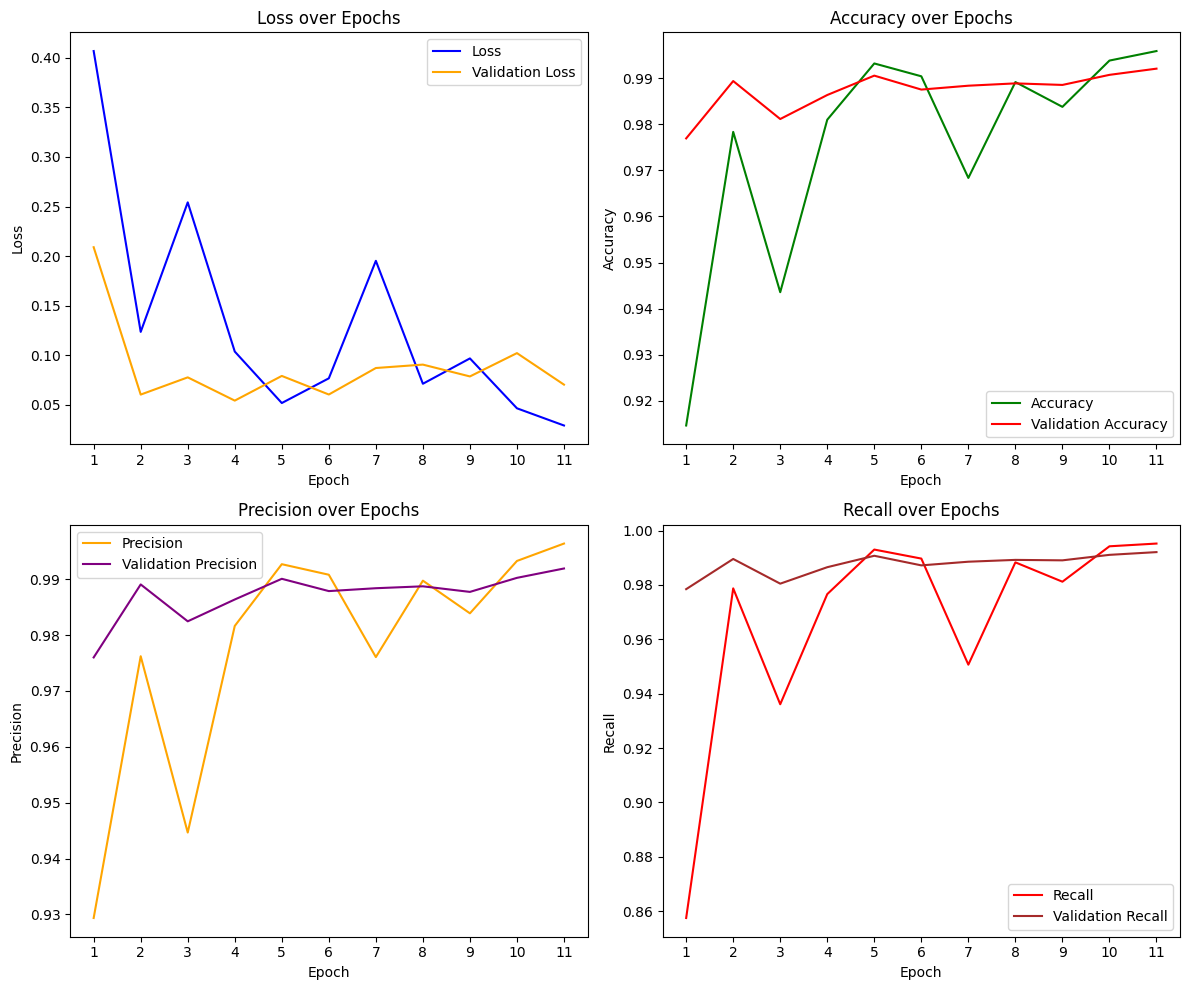

In [ ]:
plt.figure(figsize=(12, 12))
epochs = range(1, len(loss) + 1)

# Loss Plot
plt.subplot(3, 2, 1)
plt.plot(epochs, loss, label='Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

# Accuracy Plot
plt.subplot(3, 2, 2)
plt.plot(epochs, accuracy, label='Accuracy', color='green')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Precision Plot
plt.subplot(3, 2, 3)
plt.plot(epochs, precision, label='Precision', color='orange')
plt.plot(epochs, val_precision, label='Validation Precision', color='purple')
plt.title('Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.xticks(epochs)
plt.legend()

# Recall Plot
plt.subplot(3, 2, 4)
plt.plot(epochs, recall, label='Recall', color='red')
plt.plot(epochs, val_recall, label='Validation Recall', color='brown')
plt.title('Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.xticks(epochs)
plt.legend()

# F1 Plot
plt.subplot(3, 2, 5)
plt.plot(epochs, f1, label='F1', color='cyan')
plt.plot(epochs, val_f1, label='Validation F1', color='magenta')
plt.title('F1 over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()


### Model Evaluation

Validation Loss & Validation Accuraccy

In [ ]:
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

186/186 [==============================] - 5s 25ms/step - loss: 0.0603 - accuracy: 0.9876 - precision: 0.9879 - recall: 0.9872
Validation Loss: 0.06033254414796829, Validation Accuracy: 0.9875504970550537


General Evaluation Metrics

In [ ]:
# Make predictions on the validation set
val_pred_logits = model.predict(val_encodings['input_ids'])['logits']
val_probabilities = tf.nn.softmax(val_pred_logits, axis=-1)[:, 1].numpy()  # Probability of class 1 (hate speech)
val_predictions = np.argmax(val_pred_logits, axis=1)  # Predicted labels

# Ensure y_val is in binary format, not one-hot encoded
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_val_binary = np.argmax(y_val, axis=1)
else:
    y_val_binary = y_val

# Calculate evaluation metrics
accuracy = accuracy_score(y_val_binary, val_predictions)
precision = precision_score(y_val_binary, val_predictions)
recall = recall_score(y_val_binary, val_predictions)
f1 = f1_score(y_val_binary, val_predictions)
auc_roc = roc_auc_score(y_val_binary, val_probabilities)

# Print all metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC-ROC: {auc_roc:.4f}')


186/186 [==============================] - 8s 25ms/step
Accuracy: 0.9796
Precision: 0.9946
Recall: 0.9653
F1-Score: 0.9797
AUC-ROC: 0.9985


Plot ROC Curve

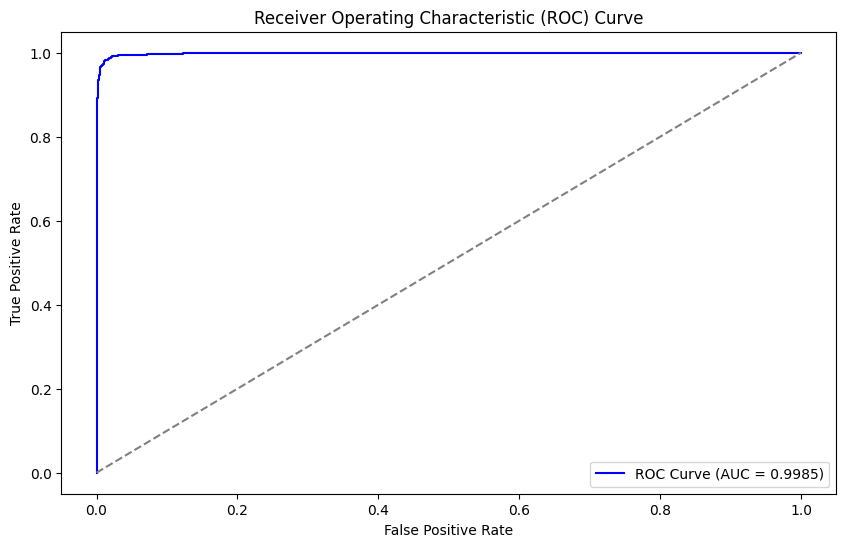

In [ ]:
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_val_binary = np.argmax(y_val, axis=1)
else:
    y_val_binary = y_val

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val_binary, val_probabilities)

# Plot the ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix

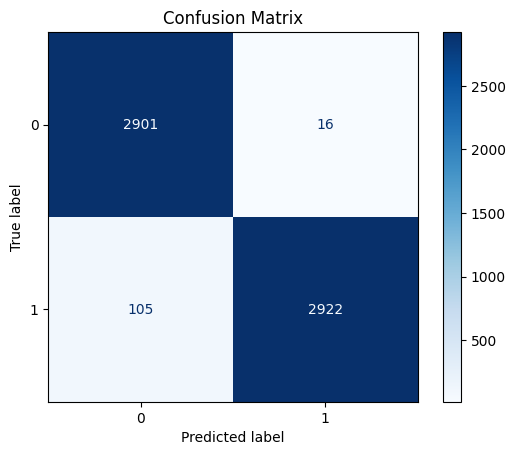

In [ ]:
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_val_binary = np.argmax(y_val, axis=1)
else:
    y_val_binary = y_val

# Calculate the confusion matrix
cm = confusion_matrix(y_val_binary, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Classification Report

In [ ]:
if len(y_val.shape) > 1 and y_val.shape[1] > 1:
    y_val_binary = np.argmax(y_val, axis=1)
else:
    y_val_binary = y_val

print("\nClassification Report:\n", classification_report(y_val_binary, val_predictions))


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2917
           1       0.99      0.97      0.98      3027

    accuracy                           0.98      5944
   macro avg       0.98      0.98      0.98      5944
weighted avg       0.98      0.98      0.98      5944



Accuracy, Precision, Recall, F1 Score Graphs

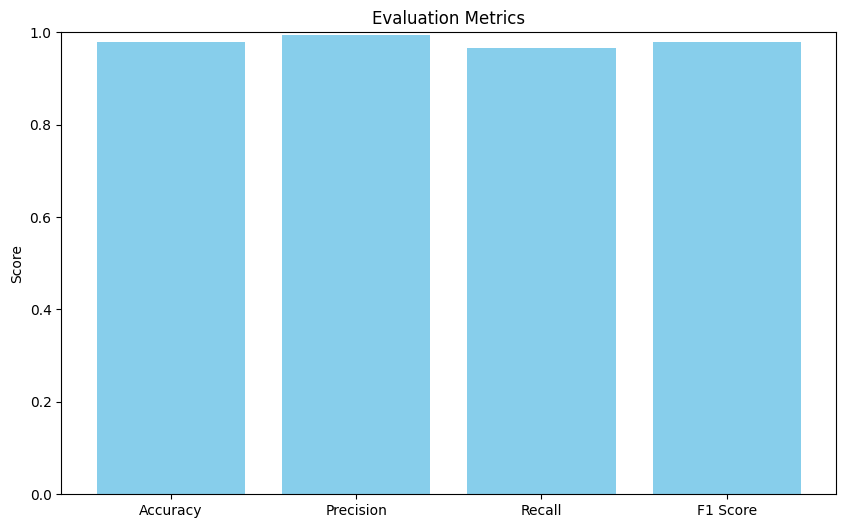

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='skyblue')
plt.title("Evaluation Metrics")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()

Save Model

In [ ]:
if not os.path.exists(FINE_TUNED_MODEL_OUTPUT_PATH):
    os.makedirs(FINE_TUNED_MODEL_OUTPUT_PATH)

model.save_pretrained(FINE_TUNED_MODEL_OUTPUT_PATH)
tokenizer.save_pretrained(FINE_TUNED_MODEL_OUTPUT_PATH)

('/content/drive/MyDrive/mixed-code-hate-speech-research/xlm_roberta_base_tuned_EPOCH_PROGRESSIVE_14/tokenizer_config.json',
 '/content/drive/MyDrive/mixed-code-hate-speech-research/xlm_roberta_base_tuned_EPOCH_PROGRESSIVE_14/special_tokens_map.json',
 '/content/drive/MyDrive/mixed-code-hate-speech-research/xlm_roberta_base_tuned_EPOCH_PROGRESSIVE_14/sentencepiece.bpe.model',
 '/content/drive/MyDrive/mixed-code-hate-speech-research/xlm_roberta_base_tuned_EPOCH_PROGRESSIVE_14/added_tokens.json')